In [3]:
%pylab inline
import numpy as np
from tqdm import trange
import torch
torch.set_printoptions(sci_mode=False)
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [4]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if not os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [5]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

loss 0.18 accuracy 0.94: 100%|██████████| 1000/1000 [00:02<00:00, 405.09it/s]


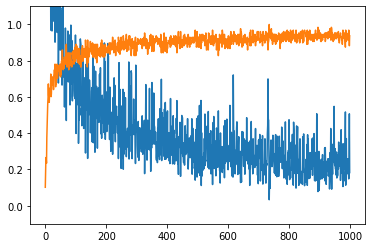

In [6]:
# training
model = BobNet()
BS = 128
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [7]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9265

tensor([0.0002], grad_fn=<NllLossBackward>)


(tensor([1.]), tensor([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

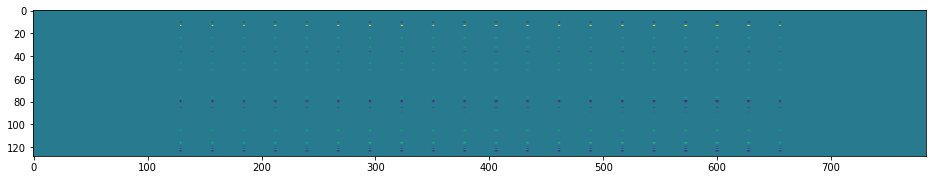

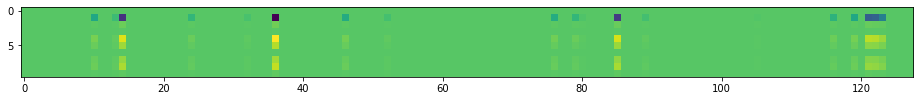

In [8]:
# understand gradients
samp = [2]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long())
print(loss)
loss.retain_grad()
loss.backward()
figsize(16,16)
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)
loss.grad, out.grad

In [9]:
# init the network
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)

# copy weights from pytorch
l1[:] = model.l1.weight.detach().numpy().T
l2[:] = model.l2.weight.detach().numpy().T

In [10]:
# numpy forward pass
def forward(x):
  x = x.dot(l1)
  x = np.maximum(x, 0)
  x = x.dot(l2)  
  return x
Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
(Y_test == Y_test_preds).mean()

0.9265

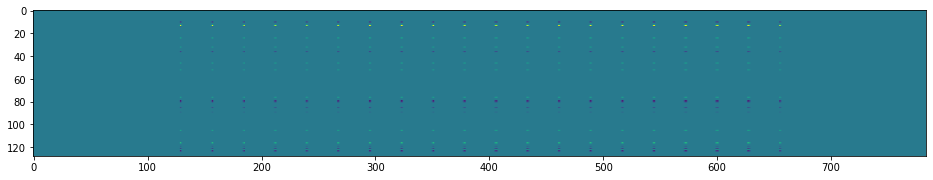

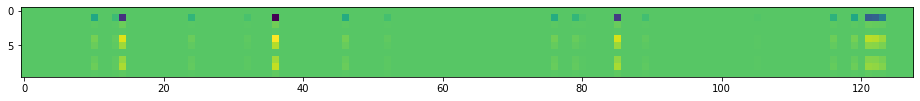

In [12]:
samp = [2]

# training
out = np.zeros((1,10), np.float32)
out[range(out.shape[0]),Y_test[samp]] = 1

# forward pass
x = X_test[samp].reshape((-1, 28*28))
x_l1 = x.dot(l1)
x_relu = np.maximum(x_l1, 0)
x_l2 = x_relu.dot(l2)
x_lsm = x_l2 - np.log(np.exp(x_l2).sum(axis=1))
x_loss = (-out * x_lsm).mean(axis=1)

# training in numpy (super hard!)
# backward pass

# will involve x_lsm, x_l2, out, d_out and produce dx_sm
d_out = -out/10

# derivative of logsoftmax
# https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
dx_lsm = d_out - np.exp(x_lsm)*d_out.sum()

# derivative of l2
d_l2 = x_relu.T.dot(dx_lsm)
dx_relu = dx_lsm.dot(l2.T)

# derivative of relu
dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

# derivative of l1
d_l1 = x.T.dot(dx_l1)

imshow(d_l1.T)
figure()
imshow(d_l2.T)

#out

#ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))